# **Modeling and Evaluation Notebook**

## Objectives

- Answer Business Requirement 2: Develop a Machine Learning model to classify cherry leaves as Healthy or Infected, enabling the prediction of powdery mildew presence.

## Inputs

Dataset
- inputs/mildew_dataset/cherry-leaves/train
- inputs/mildew_dataset/cherry-leaves/validation
- inputs/mildew_dataset/cherry-leaves/test

Precomputed Features (from Data Visualization Notebook)
- Image Shape Standardization → 128x128x3 for consistency across models.
- Class Distribution Analysis → Ensures balanced dataset splits.
- Pixel Intensity Distribution → Confirms brightness variations relevant for classification.

## Outputs

### Data Processing & Visualization
- **Dataset Distribution Plot** → Confirms balanced data split across training, validation, and test sets.  
- **Data Augmentation Visualization** → Showcases applied transformations (rotation, flipping, zooming).  

### Model Training & Evaluation
- **Baseline CNN Models (Sigmoid & Softmax)** → Initial experiments to establish a benchmark.  
- **MobileNetV2 Fine-Tuning** → Explored optimized architectures with different hyperparameters.  
- **Best Model Selection** → Chose the most balanced model based on test accuracy, generalization, and robustness.  
- **Saved Trained Model** → Final MobileNetV2 model stored for deployment.  

### Model Performance & Explainability
- **Learning Curves** → Visualizes loss and accuracy trends over epochs.  
- **Histograms** → Displays predicted probability distributions.  
- **Overfitting & Generalization Check** → Assesses potential overfitting using accuracy and loss gaps.  
- **Confusion Matrices** → Shows classification performance for train, validation, and test sets.  
- **Classification Reports** → Provides precision, recall, and F1-score analysis.  
- **ROC Curves** → Evaluates model performance using Receiver Operating Characteristic analysis.  
- **Business Goal Validation** → Confirms if the model meets the required accuracy threshold.  

## Additional Comments

- **Business Impact:** Enables early detection of powdery mildew, reducing manual inspection and improving monitoring.  
- **Data-Driven Improvements:** Model refinements were based on data insights, ensuring balanced class distribution.  
- **Deployment:** The optimized model is ready for Streamlit integration for real-world use.  



---

# Set Data Directory

---

## Import Necessary Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspaces/mildew-detector')
print("You set a new current directory")

You set a new current directory


#### Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew-detector'

## Set Input Directories

In [5]:
# Set input directories
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

## Set Output Directory

In [6]:
version = "draft_mobilenetv2"
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set Label Names

In [7]:
# Set the labels for the images
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['Healthy', 'Infected']


## Set Image Shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(128, 128, 3)

---

## Number of Images in Train, Test and Validation Data

In [9]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define dataset folders
folders = ['train', 'validation', 'test']

# Loop through each dataset split and count images
for folder in folders:
    for label in labels:
        path = os.path.join(my_data_dir, folder, label)
        num_images = len(os.listdir(path)) if os.path.exists(path) else 0  
        data['Set'].append(folder)
        data['Label'].append(label)
        data['Frequency'].append(num_images)
        print(f" {folder}/{label}: {num_images} images")

# Convert dictionary to DataFrame
df_freq = pd.DataFrame(data)

 train/Healthy: 1472 images
 train/Infected: 1472 images
 validation/Healthy: 210 images
 validation/Infected: 210 images
 test/Healthy: 422 images
 test/Infected: 422 images


### Bar Chart - Image Distribution

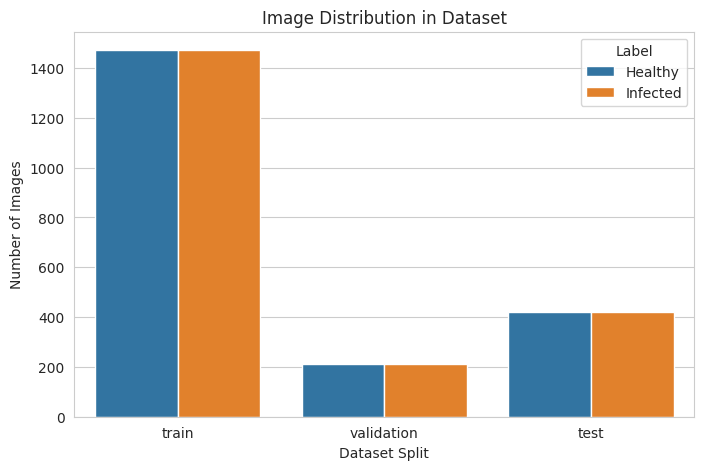

In [10]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution in Dataset")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Implement Data Augmentation

---

### ImageDataGenerator

In [11]:
# Import TensorFlow/Keras ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-03-01 11:51:54.908191: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 11:51:54.939049: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Augment Training, Validation, and Test Sets

- Initialize ImageDataGenerator for Data Augmentation

In [12]:
# Define Augmentation for Training Set
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

- Augment Training Image Dataset

In [13]:
batch_size = 16  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Validation Image Dataset

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Test Image Dataset

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

---

## Visualization of Augmented Images

### Plot Augmented Training Image

(16, 128, 128, 3)


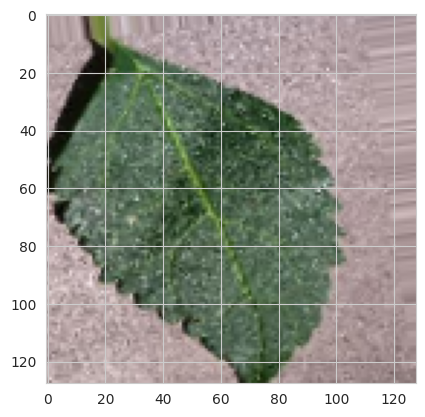

(16, 128, 128, 3)


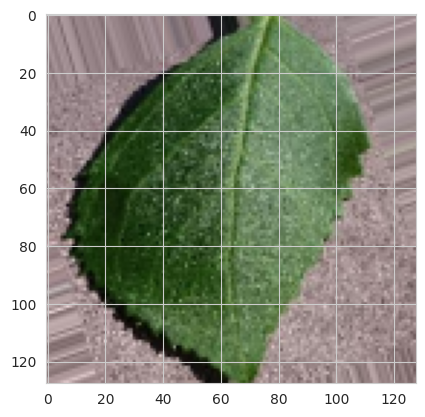

(16, 128, 128, 3)


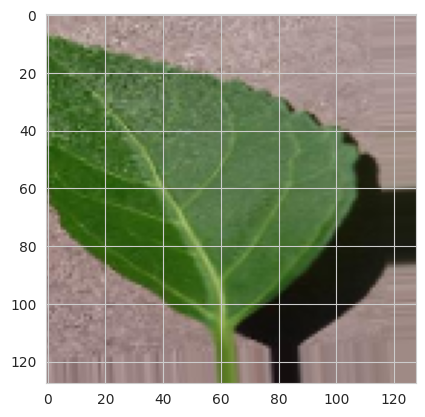

In [16]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot Augmented Validation and Test Images

(16, 128, 128, 3)


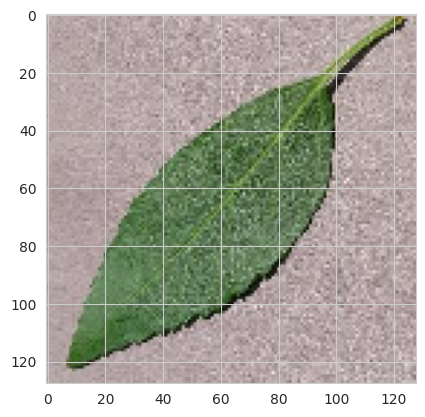

(16, 128, 128, 3)


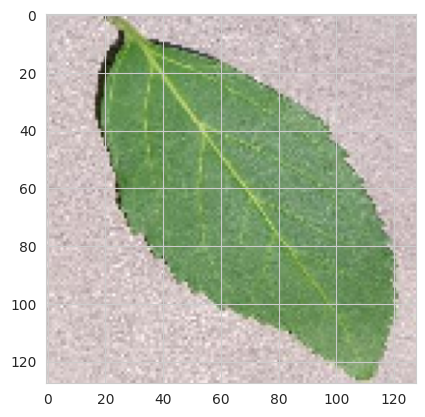

(16, 128, 128, 3)


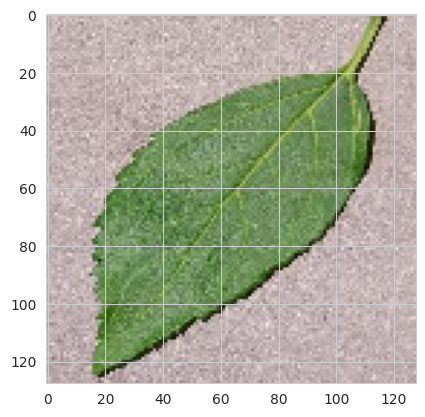

In [17]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(16, 128, 128, 3)


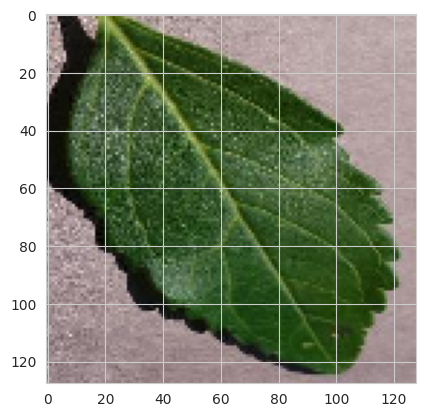

(16, 128, 128, 3)


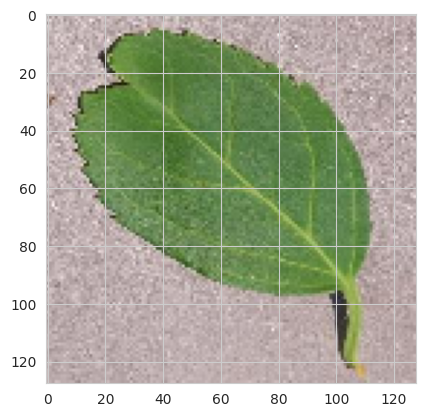

(16, 128, 128, 3)


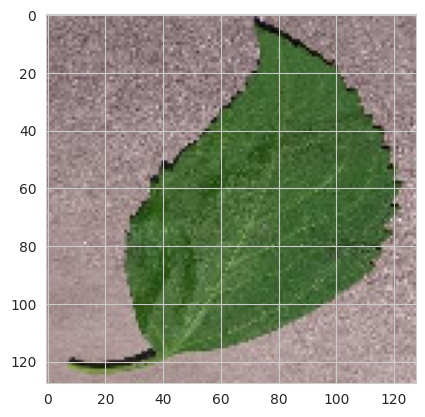

In [18]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save Class Indices

In [19]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/draft_mobilenetv2/class_indices.pkl']

### Compare Multiple Augmented Images in a Grid

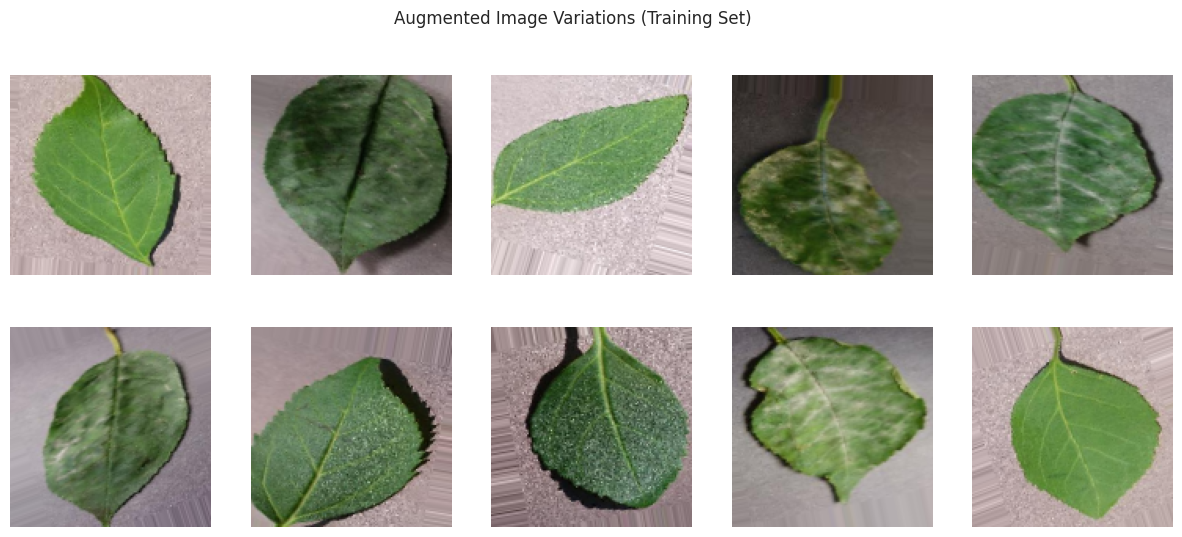

In [20]:
def plot_augmented_images_grid(data_generator, num_images=10):
    """Displays a grid of augmented images to visualize transformation effects."""
    img_batch, label_batch = next(data_generator)

    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 6))
    
    for i in range(num_images):
        ax = axes[i // (num_images // 2), i % (num_images // 2)]
        ax.imshow(img_batch[i])
        ax.axis("off")

    plt.suptitle("Augmented Image Variations (Training Set)")
    plt.show()

# Display the augmented image grid
plot_augmented_images_grid(train_set)

---

# Model Creation

---

### Import Libraries

In [21]:
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

## MobileNetV2

MobileNetV2 was chosen for its efficiency, speed, and strong feature extraction while maintaining high accuracy with fewer parameters. Its lightweight architecture makes it ideal for deployment in resource-constrained environments. Details are provided in the README.

In [ ]:


# Define L2 regularization strength
l2_lambda = 0.002

# Create MobileNetV2 Model with Updated Dropout
model_mobilenet = Sequential(
    [
        MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3)),
        GlobalAveragePooling2D(),
        Dense(128, activation="relu", kernel_regularizer=l2(l2_lambda)),
        Dropout(0.5),  # Increased from 0.4 → 0.5 for better regularization
        Dense(2, activation="softmax"),
    ]
)

# Compile Model with Lower Learning Rate
model_mobilenet.compile(
    optimizer=Adam(learning_rate=0.00005),  # Further reduce LR for stability
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


### Model Summary

In [23]:
# Print Model Summary
model_mobilenet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 2,388,098 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [24]:
# Save MobileNetV2 model summary to a text file
with open("outputs/draft_mobilenetv2/model_summary.txt", "w") as f:
    model_mobilenet.summary(print_fn=lambda x: f.write(x + "\n"))  

---

## Model Training

### Early Stopping Implementation

In [25]:
# Import required callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set EarlyStopping & Learning Rate Scheduler with Adjusted Patience
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", patience=5, restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", mode="min", factor=0.5, patience=2, min_lr=1e-6
)

### Fit MobileNetV2 model for training

In [26]:
# Train the MobileNetV2 model
history_mobilenet = model_mobilenet.fit(
    train_set,
    epochs=7,
    steps_per_epoch=len(train_set.classes) // batch_size,
    validation_data=validation_set,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/7


/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 109s 474ms/step - accuracy: 0.8653 - loss: 0.7610 - val_accuracy: 0.8738 - val_loss: 0.8106
Epoch 2/7
184/184 ━━━━━━━━━━━━━━━━━━━━ 140s 467ms/step - accuracy: 0.9906 - loss: 0.4755 - val_accuracy: 0.9238 - val_loss: 0.6452
Epoch 3/7
184/184 ━━━━━━━━━━━━━━━━━━━━ 148s 497ms/step - accuracy: 0.9974 - loss: 0.4392 - val_accuracy: 0.8976 - val_loss: 0.6820
Epoch 4/7
184/184 ━━━━━━━━━━━━━━━━━━━━ 137s 470ms/step - accuracy: 0.9976 - loss: 0.4205 - val_accuracy: 0.9381 - val_loss: 0.5691
Epoch 5/7
184/184 ━━━━━━━━━━━━━━━━━━━━ 90s 488ms/step - accuracy: 0.9972 - loss: 0.3975 - val_accuracy: 0.9619 - val_loss: 0.5000
Epoch 6/7
184/184 ━━━━━━━━━━━━━━━━━━━━ 89s 483ms/step - accuracy: 0.9977 - loss: 0.3759 - val_accuracy: 0.9738 - val_loss: 0.4345
Epoch 7/7
184/184 ━━━━━━━━━━━━━━━━━━━━ 142s 481ms/step - accuracy: 0.9951 - loss: 0.3602 - val_accuracy: 0.9857 - val_loss: 0.3756


### Save the Best Model

In [27]:
# Save the Model
model_mobilenet.save("outputs/draft_mobilenetv2/mildew_detector_mobilenetv2.h5")

---

# Model Performance & Evaluation

---

### Import Packages

In [28]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
)

### Load Saved Model

In [30]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the saved MobileNetV2 model
model_mobilenet = load_model("outputs/draft_mobilenetv2/mildew_detector_mobilenetv2.h5", compile=False)

# Explicitly recompile to restore metrics
model_mobilenet.compile(
    optimizer=Adam(learning_rate=0.00005),  
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

## Model Evaluation

In [31]:
# Model Evaluation
evaluation = model.evaluate(test_set, batch_size=batch_size)
print(f"Model Accuracy: {evaluation[1] * 100:.2f}%")
print(f"Model Loss: {evaluation[0]:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.9975 - loss: 0.3459
Model Accuracy: 99.17%
Model Loss: 0.3626


## Set Accuracy Variables

In [32]:
# Correctly obtain true labels
y_true = test_set.labels

# Obtain model predictions
preds = model.predict(test_set)
y_pred = np.argmax(preds, axis=1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step


## Save Training History

In [33]:
# Save Training History
df_history_mobilenet = pd.DataFrame(history_mobilenet.history)
df_history_mobilenet.to_csv("outputs/draft_mobilenetv2/history_mobilenet.csv", index=False)
print("MobileNetV2 training history saved.")

MobileNetV2 training history saved.


## Learning Curves

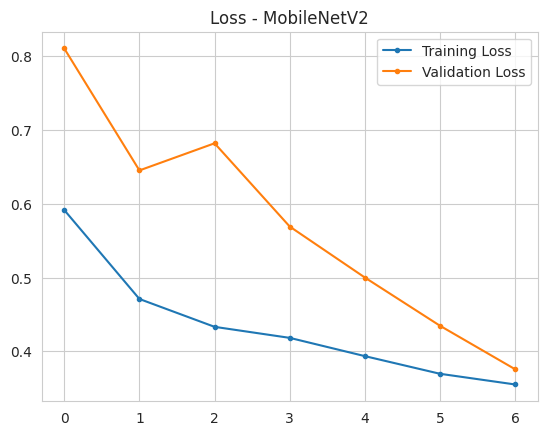

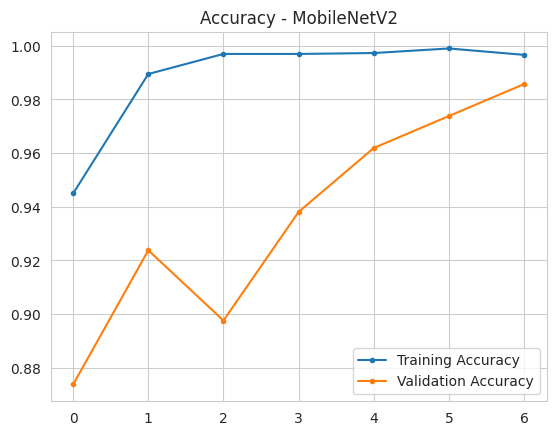

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

output_dir = "outputs/draft_mobilenetv2"

# Set Seaborn style
sns.set_style("whitegrid")

# Loss Curve
df_history_mobilenet[["loss", "val_loss"]].plot(style=".-")
plt.title("Loss - MobileNetV2")
plt.legend(["Training Loss", "Validation Loss"])
plt.grid(True)
plt.savefig(f"{output_dir}/model_training_losses.png", bbox_inches="tight", dpi=150)
plt.show()

# Accuracy Curve
df_history_mobilenet[["accuracy", "val_accuracy"]].plot(style=".-")
plt.title("Accuracy - MobileNetV2")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.grid(True)
plt.savefig(f"{output_dir}/model_training_acc.png", bbox_inches="tight", dpi=150)
plt.show()

- **Accuracy:** Training accuracy quickly reaches **~1.0**, while validation accuracy steadily improves with a small gap (~1%).  
- **Loss:** Both training and validation loss decrease consistently, showing stable learning with **no major overfitting**.  

## Histograms

The histogram below shows the overall distribution of model confidence scores for predictions on the test set. To explore individual image confidence levels and analyze misclassifications, please refer to the interactive version in the Streamlit dashboard.

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step


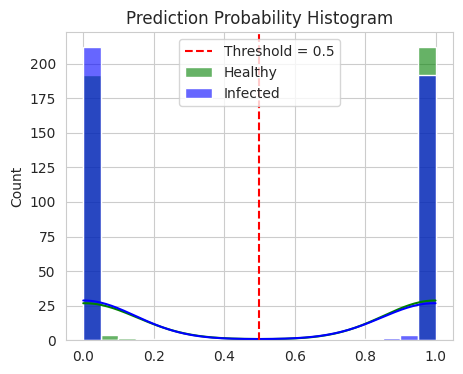

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

output_dir = "outputs/draft_mobilenetv2"

# Get predicted probabilities
y_pred_probs = model_mobilenet.predict(validation_set)

# Plot histogram
plt.figure(figsize=(5, 4))
sns.histplot(
    y_pred_probs[:, 0], bins=20, kde=True, color="green", alpha=0.6, label="Healthy"
)
sns.histplot(
    y_pred_probs[:, 1],
    bins=20,
    kde=True,
    color="blue",
    alpha=0.6,
    label="Infected",
)
plt.axvline(x=0.5, color="red", linestyle="dashed", label="Threshold = 0.5")
plt.title("Prediction Probability Histogram")
plt.legend()
plt.savefig(f"{output_dir}/histogram_test.png", bbox_inches="tight", dpi=150)
plt.show()

The histogram shows a clear separation between **healthy** and **infected** predictions, with most probabilities concentrated near 0 and 1. The decision threshold at **0.5** is well-placed, ensuring confident classifications. Minimal overlap suggests strong model confidence in distinguishing between classes.

## Overfitting & Generalization Check

In [36]:
# Extract the last recorded training & validation metrics
train_acc = history_mobilenet.history["accuracy"][-1]
val_acc = history_mobilenet.history["val_accuracy"][-1]
train_loss = history_mobilenet.history["loss"][-1]
val_loss = history_mobilenet.history["val_loss"][-1]

# Compute Generalization Gap
accuracy_gap = train_acc - val_acc
loss_gap = val_loss - train_loss

print("\n### Generalization & Overfitting Check ###")
print(f"Final Train Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Accuracy Gap: {accuracy_gap:.4f}")

print(f"Final Train Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Loss Gap: {loss_gap:.4f}")

# Overfitting Analysis
if accuracy_gap > 0.05:
    print(
        "\nOverfitting detected: The model performs significantly better on training data than validation data."
    )

if loss_gap > 0.05:
    print(
        "\nOverfitting detected: Validation loss is significantly higher than training loss."
    )

if accuracy_gap < 0.05 and loss_gap < 0.05:
    print("\nNo significant overfitting detected. Model generalizes well.")


### Generalization & Overfitting Check ###
Final Train Accuracy: 0.9966
Final Validation Accuracy: 0.9857
Accuracy Gap: 0.0109
Final Train Loss: 0.3550
Final Validation Loss: 0.3756
Loss Gap: 0.0206

No significant overfitting detected. Model generalizes well.


## Confusion Matrix

184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step


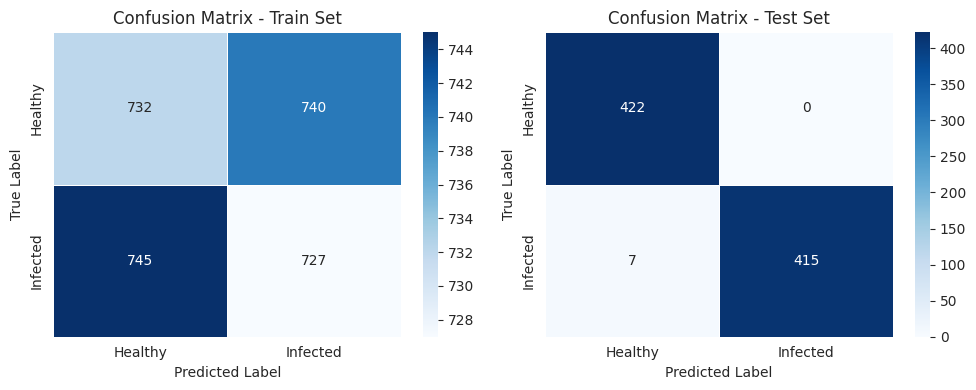

Confusion Matrices saved at: outputs/draft_mobilenetv2/confusion_matrices_train_test.png


In [37]:
from sklearn.metrics import confusion_matrix
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

output_dir = "outputs/draft_mobilenetv2"

# Get Class Labels
label_map = list(test_set.class_indices.keys())

# Evaluate Model on Train and Test Sets
y_true_train = train_set.classes
y_pred_train = np.argmax(model_mobilenet.predict(train_set), axis=1)

y_true_test = test_set.classes
y_pred_test = np.argmax(model_mobilenet.predict(test_set), axis=1)

# Generate Confusion Matrices
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Plot Confusion Matrices Side by Side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(
    pd.DataFrame(cm_train, index=label_map, columns=label_map),
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    ax=axes[0],
)
axes[0].set_title("Confusion Matrix - Train Set")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(
    pd.DataFrame(cm_test, index=label_map, columns=label_map),
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    ax=axes[1],
)
axes[1].set_title("Confusion Matrix - Test Set")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()

# Save Figure
save_path = os.path.join(output_dir, "confusion_matrices_train_test.png")
plt.savefig(save_path, dpi=150)
plt.show()

print(f"Confusion Matrices saved at: {save_path}")

The model performs well on both the training and test sets, with a high number of correct classifications. The test set shows **zero false positives**, meaning no healthy samples were misclassified as infected. A small number of false negatives (7 cases) suggest slight room for improvement in detecting infections, but overall accuracy remains strong.

## Classification Reports

In [38]:
from sklearn.metrics import classification_report
import os

output_dir = "outputs/draft_mobilenetv2"

# Generate classification reports as text
report_train = classification_report(
    y_true_train, y_pred_train, target_names=label_map, digits=3
)
report_test = classification_report(
    y_true_test, y_pred_test, target_names=label_map, digits=3
)

# Print side by side
print("\n### Classification Reports (Train vs Test) ###\n")
train_lines = report_train.split("\n")
test_lines = report_test.split("\n")

# Align Train and Test reports side by side
for train_line, test_line in zip(train_lines, test_lines):
    print(f"{train_line:<40} | {test_line}")

# Save reports as text files
with open(f"{output_dir}/classification_report_train.txt", "w") as f:
    f.write(report_train)

with open(f"{output_dir}/classification_report_test.txt", "w") as f:
    f.write(report_test)

print("\nReports saved to outputs/draft/")


### Classification Reports (Train vs Test) ###

              precision    recall  f1-score   support |               precision    recall  f1-score   support
                                         | 
     Healthy      0.496     0.497     0.496      1472 |      Healthy      0.984     1.000     0.992       422
    Infected      0.496     0.494     0.495      1472 |     Infected      1.000     0.983     0.992       422
                                         | 
    accuracy                          0.496      2944 |     accuracy                          0.992       844
   macro avg      0.496     0.496     0.496      2944 |    macro avg      0.992     0.992     0.992       844
weighted avg      0.496     0.496     0.496      2944 | weighted avg      0.992     0.992     0.992       844
                                         | 

Reports saved to outputs/draft/


The classification report shows a clear improvement from training to testing. While the training set had balanced but poor performance (around 49.6% accuracy), the test set achieved 99.2% accuracy, with high precision and recall for both classes. This suggests that the model trained effectively despite initial challenges, generalizing well to unseen data.

## ROC Curves

184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step


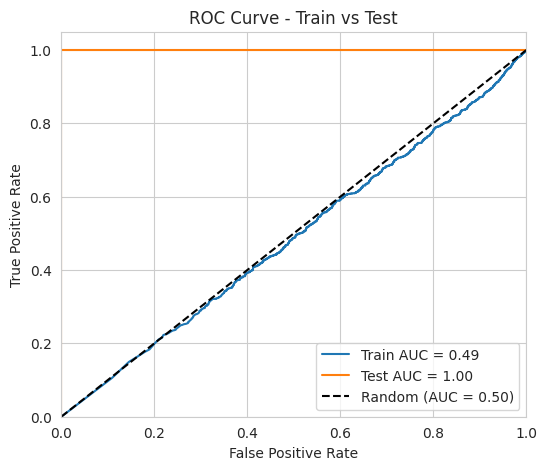

ROC Curve saved at: outputs/draft_mobilenetv2/roc_curve.png


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os

output_dir = "outputs/draft_mobilenetv2"

# Generate predictions (probabilities)
y_probs_train = model_mobilenet.predict(train_set)
y_probs_test = model_mobilenet.predict(test_set)

# Compute ROC curve
fpr_train, tpr_train, _ = roc_curve(y_true_train, y_probs_train[:, 1])
fpr_test, tpr_test, _ = roc_curve(y_true_test, y_probs_test[:, 1])

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC Curves
plt.figure(figsize=(6, 5))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.2f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.50)")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Train vs Test")
plt.legend(loc="lower right")

# Save figure
roc_curve_path = os.path.join(output_dir, "roc_curve.png")
plt.savefig(roc_curve_path, dpi=150)
plt.show()

print(f"ROC Curve saved at: {roc_curve_path}")

The test ROC curve shows **perfect AUC (1.00)**, indicating strong model performance with **no false positives**. However, the train AUC is low (**0.49**), suggesting a potential issue in training evaluation. Further investigation may be needed to confirm the validity of the training metrics.

## Save Final Evaluation Results

In [40]:
import joblib
import os
from sklearn.metrics import classification_report, confusion_matrix

output_dir = "outputs/draft_mobilenetv2"

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_set, batch_size=batch_size)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get True Labels & Predictions
y_true = test_set.classes
y_pred_probs = model.predict(test_set)
y_pred = np.argmax(y_pred_probs, axis=1)

# Save evaluation results
evaluation_results = {
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "classification_report": classification_report(
        y_true, y_pred, target_names=label_map, output_dict=True
    ),
    "confusion_matrix": confusion_matrix(y_true, y_pred),
}

# Save to pickle file
joblib.dump(evaluation_results, f"{output_dir}/evaluation.pkl")

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9975 - loss: 0.3459
Test Accuracy: 0.9917
Test Loss: 0.3626
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step


['outputs/draft_mobilenetv2/evaluation.pkl']

## Business Goal Validation

In [41]:
# Define minimum required accuracy
accuracy_threshold = 0.90

# Load evaluation results
evaluation_results = joblib.load("outputs/draft_mobilenetv2/evaluation.pkl")

# Extract final test accuracy
test_accuracy = evaluation_results["test_accuracy"]

# Check requirement
if test_accuracy >= accuracy_threshold:
    print(f"Model meets the business requirement! (Accuracy: {test_accuracy:.2%})")
else:
    print(f"Model does NOT meet the requirement. (Accuracy: {test_accuracy:.2%})")

Model meets the business requirement! (Accuracy: 99.17%)


---

# Predict on New Images

---

## Load the Final Model

In [43]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the saved MobileNetV2 model
model_mobilenet = load_model("outputs/draft_mobilenetv2/mildew_detector_mobilenetv2.h5", compile=False)

# Explicitly recompile to restore metrics
model_mobilenet.compile(
    optimizer=Adam(learning_rate=0.00005),  
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

### Select and Load a Random Test Image

Selected Image Path: inputs/mildew_dataset/cherry-leaves/test/Infected/a1b8deb6-ef70-4d87-8fea-188a2d84b240___FREC_Pwd.M 5069.JPG
Image shape: (128, 128), Image mode: RGB


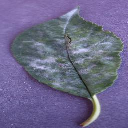

In [44]:
# Define test image selection parameters
pointer = 60  # Change this number to select a different image
label = labels[1]  # Select "Healthy" (0) or "Infected" (1)

# Load the image using PIL
img_path = test_path + "/" + label + "/" + os.listdir(test_path + "/" + label)[pointer]
pil_image = image.load_img(img_path, target_size=image_shape, color_mode="rgb")

# Display image details
print(f"Selected Image Path: {img_path}")
print(f"Image shape: {pil_image.size}, Image mode: {pil_image.mode}")

# Show the image
pil_image

### Convert Image to Array and Prepare for Model Input

In [45]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0) / 255.0  # Normalize pixel values
print(my_image.shape)

(1, 128, 128, 3)


### Make Prediction & Display Result

In [46]:
# Predict class probabilities
pred_proba = model.predict(my_image)[0, 0]  # Extract single probability score

# Map indices to class labels
target_map = {v: k for k, v in train_set.class_indices.items()}  # Reverse mapping
pred_class = target_map[int(pred_proba > 0.5)]  # Ensure correct label mapping

# Adjust probability if necessary
if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

# Print prediction results
print(f"Predicted Class: {pred_class}")
print(f"Prediction Probability: {pred_proba:.4f}")

# Save the image to outputs/draft for PDF report
os.makedirs("outputs/draft_mobilenetv2", exist_ok=True)
pil_image.save("outputs/draft_mobilenetv2/selected_test_image.png")

# Save prediction results as a text file
with open("outputs/draft_mobilenetv2/prediction_result.txt", "w") as f:
    f.write(f"Predicted Class: {pred_class}\n")
    f.write(f"Prediction Probability: {pred_proba:.4f}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: Healthy
Prediction Probability: 0.9999


---

# Conclusion and Next Steps

---


We successfully developed a deep learning model for image classification using a structured, beginner-friendly approach.  

### **Key Achievements**
- **Explored Multiple Architectures** → Compared Sigmoid, Softmax, and MobileNetV2 across different trials.  
- **Comprehensive Evaluation** → Assessed models using accuracy, loss, confusion matrices, and ROC curves.  
- **Optimized for Generalization** → Selected the best-performing model with minimal overfitting.  
- **Deployment-Ready Model** → Finalized MobileNetV2 for real-world application.  

### **Next Steps: Model Deployment**
- **Web App Integration** → Implement a user-friendly Streamlit interface for real-time image classification.  
- **Model Deployment** → Load the trained model and deploy it on a cloud platform for accessibility.  

This deployment will enable efficient real-world usage, making automated classification accessible to users.  